## Test PSF measurement in the stack

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

3


Make a couple of test images to test the PSF measurement on...

In [61]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.
breakLimit = 1.050

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

No module named utils
LSSTSW has not been set up.


See `pipe_tasks/examples/measurePsfTask.py`.

In [3]:
import lsst.pipe.tasks.measurePsf as measurePsf
import lsst.afw.table as afwTable
import lsst.ip.diffim as ipDiffim  # for detection - needs NaiveDipoleCentroid (registered by my routine)

exp = testObj.im1.asAfwExposure()
sources = dit.doDetection(exp, asDF=False)

In [4]:
config = measurePsf.MeasurePsfConfig()
schema = afwTable.SourceTable.makeMinimalSchema()

psfDeterminer = config.psfDeterminer.apply()
psfDeterminer.config.sizeCellX = 128
psfDeterminer.config.sizeCellY = 128
psfDeterminer.config.spatialOrder = 1
psfDeterminer.config.nEigenComponents = 3
task = measurePsf.MeasurePsfTask(schema=schema, config=config)

result = task.run(exp, sources)
psf = result.psf
cellSet = result.cellSet

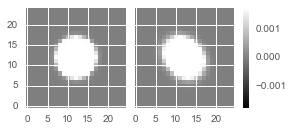

In [5]:
dit.plotImageGrid((testObj.im1.psf, testObj.im2.psf))

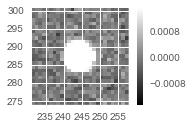

In [6]:
dit.plotImageGrid((psf.computeImage(),)) #, clim=(-0.001,0.001))

In [7]:
def measurePsf(exp):
    import lsst.pipe.tasks.measurePsf as measurePsf
    import lsst.afw.table as afwTable
    import lsst.ip.diffim as ipDiffim  # for detection - needs NaiveDipoleCentroid (registered by my routine)
    import lsst.meas.algorithms        as measAlg

    # The old (meas_algorithms) SdssCentroid assumed this by default if it
    # wasn't specified; meas_base requires us to be explicit.
    psf = measAlg.DoubleGaussianPsf(11, 11, 0.01)
    exp.setPsf(psf)

    im = exp.getMaskedImage().getImage()
    im -= np.median(im.getArray())

    sources = dit.doDetection(exp, asDF=False)
    config = measurePsf.MeasurePsfConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()

    psfDeterminer = config.psfDeterminer.apply()
    psfDeterminer.config.sizeCellX = 128
    psfDeterminer.config.sizeCellY = 128
    psfDeterminer.config.spatialOrder = 1
    psfDeterminer.config.nEigenComponents = 3
    task = measurePsf.MeasurePsfTask(schema=schema, config=config)

    result = task.run(exp, sources)
    return result

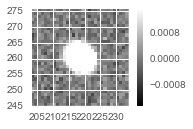

In [8]:
res = measurePsf(testObj.im2.asAfwExposure())
dit.plotImageGrid((res.psf.computeImage(),)) #, clim=(-0.001,0.001))

No module named utils
LSSTSW has not been set up.
(25, 25) (41, 41)
0.999999962956


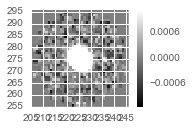

In [9]:
reload(dit)
res = dit.measurePsf(testObj.im2.asAfwExposure(), measurePsfAlg='psfex')
psf = res.psf.computeImage()
print testObj.im2.psf.shape, psf.getDimensions()
print psf.getArray().sum()
dit.plotImageGrid((res.psf.computeImage(),)) #, clim=(-0.001,0.001))

No module named utils
LSSTSW has not been set up.
(25, 25) (31, 31)
0.999945573135


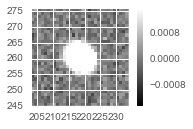

In [10]:
reload(dit)
res = dit.measurePsf(testObj.im2.asAfwExposure(), measurePsfAlg='pca')
psf = res.psf.computeImage()
print testObj.im2.psf.shape, psf.getDimensions()
print psf.getArray().sum()
dit.plotImageGrid((res.psf.computeImage(),)) #, clim=(-0.001,0.001))

See how it works on a *really* crowded field.

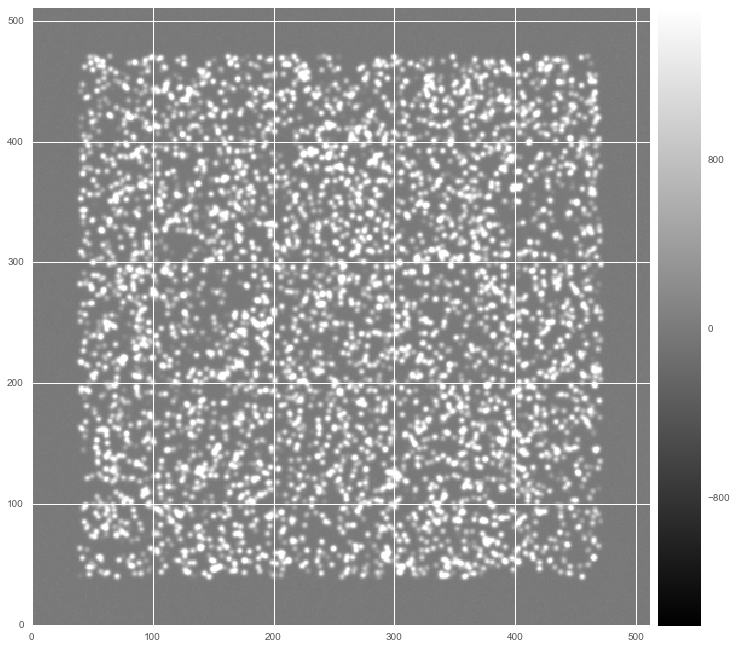

In [11]:
testObj2 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=5000, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

fig = plt.figure(1, (12, 12))
dit.plotImageGrid((testObj2.im1.im,))

No module named utils
LSSTSW has not been set up.
(25, 25) (41, 41)
1.00000051679


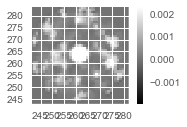

In [12]:
reload(dit)
res = dit.measurePsf(testObj2.im1.asAfwExposure(), measurePsfAlg='psfex')
psf1 = res.psf.computeImage()
print testObj2.im1.psf.shape, psf1.getDimensions()
print psf1.getArray().sum()
dit.plotImageGrid((psf1,)) #, clim=(-0.001,0.001))

(25, 25) (41, 41)
1.00000023748


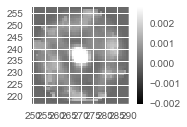

In [13]:
res = dit.measurePsf(testObj2.im2.asAfwExposure(), measurePsfAlg='psfex')
psf2 = res.psf.computeImage()
print testObj2.im2.psf.shape, psf2.getDimensions()
print psf2.getArray().sum()
dit.plotImageGrid((psf2,)) #, clim=(-0.001,0.001))

Try a really sparse field.

[[   429.40377321     49.59226944   6742.90839861   6742.90839861]
 [   261.72846073    372.31941309      0.           1500.        ]
 [   272.35445943     61.21064062  12473.85031986  12473.85031986]
 [   326.32515954    240.51121657      0.           1500.        ]
 [   313.27846152    445.67145029   7847.37657668   7847.37657668]
 [   192.32379077    133.31680266      0.           1500.        ]
 [    51.48292303    195.72825837  23356.45076723  23356.45076723]
 [   111.23992084     53.49833047  17834.51121296  17834.51121296]
 [   418.98648529    171.04319442  16657.08024209  16657.08024209]
 [    69.23061647    121.14336757  15364.49621383  15364.49621383]
 [   199.07598062     94.3748016    4897.34009925   4897.34009925]
 [    89.78075273    218.52745544  25300.12466264  25300.12466264]
 [    81.5027755     447.15324488  10712.61537283  10712.61537283]
 [    76.10473972     56.52605549   3362.01195937   3362.01195937]
 [    77.46554871    452.48427913  21145.15830741  21145.15830

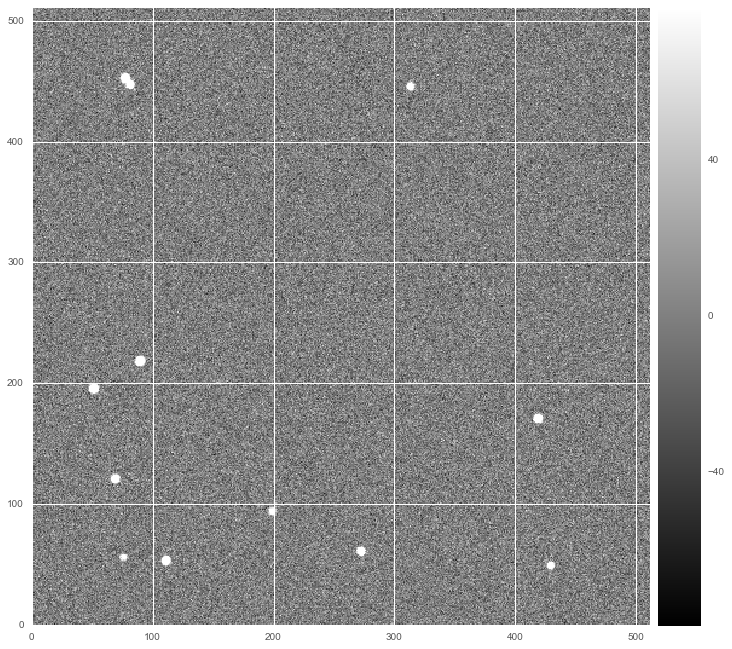

In [14]:
testObj3 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=15, sourceFluxRange=(2500,30000), 
                         seed=66, psfSize=13)

print testObj3.centroids
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((testObj3.im2.im,))

No module named utils
LSSTSW has not been set up.
(25, 25) (41, 41)
0.999999855974


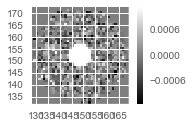

In [15]:
reload(dit)
res = dit.measurePsf(testObj3.im1.asAfwExposure(), measurePsfAlg='psfex')
psf1 = res.psf.computeImage()
print testObj3.im1.psf.shape, psf1.getDimensions()
print psf1.getArray().sum()
dit.plotImageGrid((psf1,)) #, clim=(-0.001,0.001))

(25, 25) (41, 41)
0.999999603713


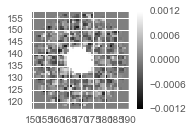

In [16]:
res = dit.measurePsf(testObj3.im2.asAfwExposure(), measurePsfAlg='psfex')
psf2 = res.psf.computeImage()
print testObj3.im2.psf.shape, psf2.getDimensions()
print psf2.getArray().sum()
dit.plotImageGrid((psf2,)) #, clim=(-0.001,0.001))

In [89]:
reload(dit)
testObj4 = testObj.clone()
testObj4.reverseImages()

No module named utils
LSSTSW has not been set up.


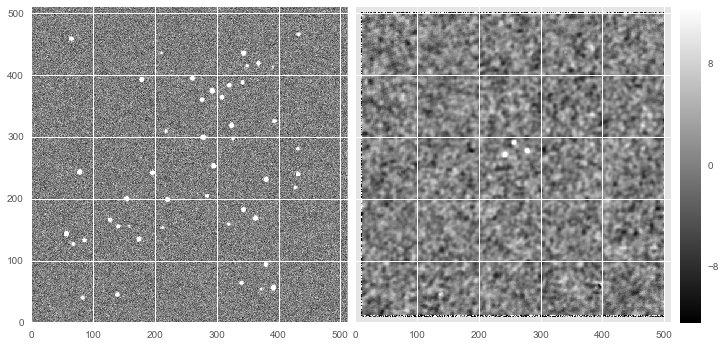

In [90]:
res = testObj4.doALInStack(doDecorr=False, doPreConv=True)
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((testObj4.im1.im, -res.subtractedExposure.getMaskedImage().getImage().getArray()))

1.0 1.0


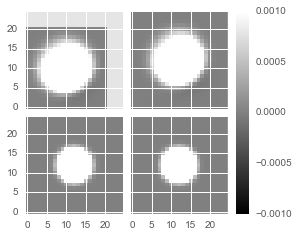

In [91]:
kimg = tmp = dit.alPsfMatchingKernelToArray(res.psfMatchingKernel, res.subtractedExposure)
preConvKernel = testObj4.im2.psf

padSize0 = preConvKernel.shape[0]//2 - kimg.shape[0]//2
padSize1 = preConvKernel.shape[1]//2 - kimg.shape[1]//2
kimg = np.pad(kimg, ((padSize0, padSize0), (padSize1, padSize1)), mode='constant',
              constant_values=0)
print tmp.sum(), kimg.sum()
dit.plotImageGrid((tmp, kimg, preConvKernel, testObj4.im2.psf), clim=(-0.001,0.001))

No module named utils
LSSTSW has not been set up.
300.040776194 300.159065001
-2.63748115888 20.677453335 0.914368703307


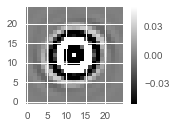

In [127]:
reload(dit)
sig1squared = dit.computeVarianceMean(testObj.im1.asAfwExposure())
sig2squared = dit.computeVarianceMean(testObj.im2.asAfwExposure())
print sig1squared, sig2squared

pck = dit.computeDecorrelationKernel(kimg, sig1squared, sig2squared,
                                     preConvKernel=preConvKernel, delta=1.)
print pck.min(), pck.max(), pck.sum()
dit.plotImageGrid((pck,))

1.0816 1.0816
(6.83047368666e-16+3.03576608296e-17j) (-1.24379673228e-15+2.46519032882e-32j)
24.5173494747 45.4562432965


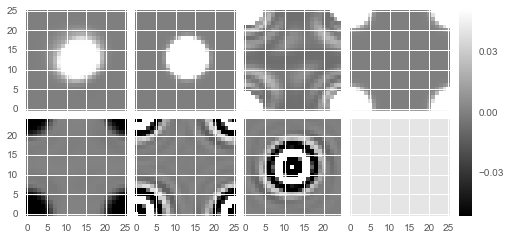

In [146]:
import scipy.fftpack
tvar = sig1squared
svar = sig2squared

kappa = dit.fixOddKernel(kimg)
#kappa /= kappa.sum()
pc = dit.fixOddKernel(preConvKernel)
#pc /= pc.sum()

kft = scipy.fftpack.fft2(kappa)
pcft = scipy.fftpack.fft2(pc)

print kappa.sum(), pc.sum()
print kft.sum(), pcft.sum()
print np.abs(kft).sum(), np.abs(pcft).sum()

delta = 1.
out = np.sqrt((svar + tvar + delta) / (svar * np.abs(pcft)**2 + tvar * np.abs(kft)**2 + delta))
#out = scipy.fftpack.fftshift(out)  # I can't figure out why we need to fftshift sometimes but not others.
pck = scipy.fftpack.ifft2(out)
#if np.argmax(pck.real) == 0:  # I can't figure out why we need to ifftshift sometimes but not others.
#    pck = scipy.fftpack.ifftshift(pck)
fkernel = dit.fixEvenKernel(pck.real)
dit.plotImageGrid((kappa, pc, np.abs(kft)**2, np.abs(pcft)**2, out, pck.real, fkernel))

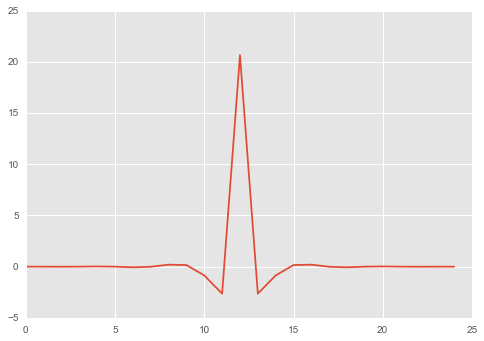

In [147]:
plt.plot(fkernel[12,:])

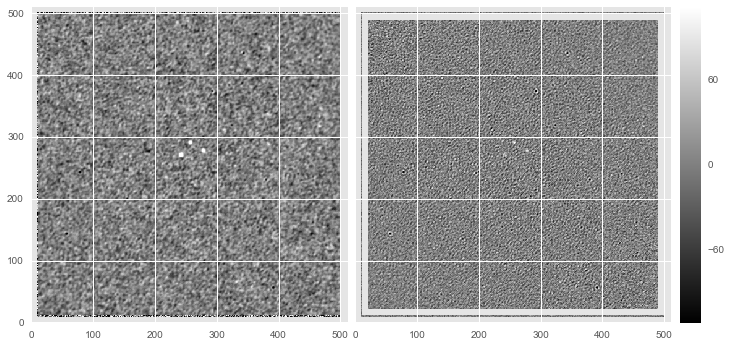

In [148]:
diffim, _ = dit.doConvolve(res.subtractedExposure, fkernel, use_scipy=False)
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((-res.subtractedExposure.getMaskedImage().getImage().getArray(),
                  -diffim.getMaskedImage().getImage().getArray()))

OK, looks like if I turn off all of the fftshifing and ifftshifting, and add a delta=1 to both numerator and denominator, then at least it doesnt blow up.

No module named utils
LSSTSW has not been set up.


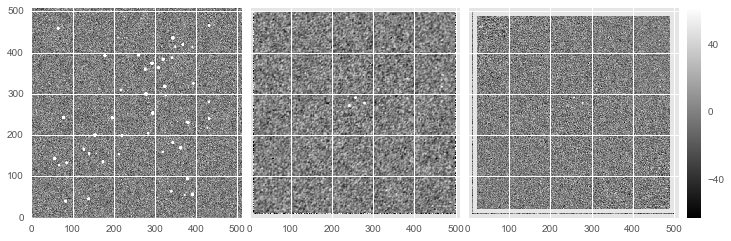

In [149]:
reload(dit)
testObj4 = testObj.clone()
testObj4.reverseImages()
res = testObj4.doALInStack(doDecorr=True, doPreConv=True)
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((testObj4.im2.im, -res.subtractedExposure.getMaskedImage().getImage().getArray(),
                   -res.decorrelatedDiffim.getMaskedImage().getImage().getArray()))

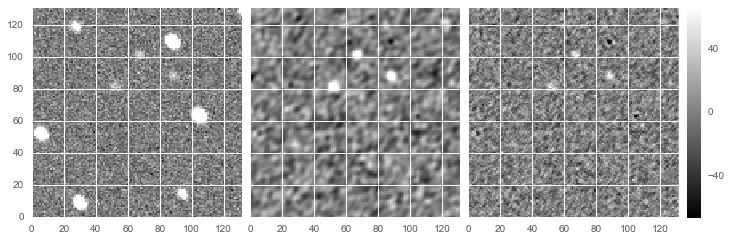

In [155]:
xim = yim = np.arange(-256, 256, 1)
x1d, x2d, y1d, y2d = 190, 512-190, 190, 512-190   # limits for display
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((testObj4.im1.im[x1d:x2d,y1d:y2d], 
                   -res.subtractedExposure.getMaskedImage().getImage().getArray()[x1d:x2d,y1d:y2d],
                   -res.decorrelatedDiffim.getMaskedImage().getImage().getArray()[x1d:x2d,y1d:y2d]))

In [153]:
sizeme(dit.doDetection(res.decorrelatedDiffim))

,base_CircularApertureFlux_12_0_flag,base_CircularApertureFlux_12_0_flag_apertureTruncated,base_CircularApertureFlux_12_0_flux,base_CircularApertureFlux_12_0_fluxSigma,base_CircularApertureFlux_17_0_flag,base_CircularApertureFlux_17_0_flag_apertureTruncated,base_CircularApertureFlux_17_0_flux,base_CircularApertureFlux_17_0_fluxSigma,base_CircularApertureFlux_25_0_flag,base_CircularApertureFlux_25_0_flag_apertureTruncated,base_CircularApertureFlux_25_0_flux,base_CircularApertureFlux_25_0_fluxSigma,base_CircularApertureFlux_35_0_flag,base_CircularApertureFlux_35_0_flag_apertureTruncated,base_CircularApertureFlux_35_0_flux,base_CircularApertureFlux_35_0_fluxSigma,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_3_0_flux,base_CircularApertureFlux_3_0_fluxSigma,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_flux,base_CircularApertureFlux_4_5_fluxSigma,base_CircularApertureFlux_50_0_flag,base_CircularApertureFlux_50_0_flag_apertureTruncated,base_CircularApertureFlux_50_0_flux,base_CircularApertureFlux_50_0_fluxSigma,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_flux,base_CircularApertureFlux_6_0_fluxSigma,base_CircularApertureFlux_70_0_flag,base_CircularApertureFlux_70_0_flag_apertureTruncated,base_CircularApertureFlux_70_0_flux,base_CircularApertureFlux_70_0_fluxSigma,base_CircularApertureFlux_9_0_flag,base_CircularApertureFlux_9_0_flag_apertureTruncated,base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_flux,base_CircularApertureFlux_9_0_fluxSigma,base_GaussianCentroid_flag,base_GaussianCentroid_flag_noPeak,base_GaussianCentroid_flag_resetToPeak,base_GaussianCentroid_x,base_GaussianCentroid_y,base_GaussianFlux_flag,base_GaussianFlux_flux,base_GaussianFlux_fluxSigma,base_NaiveCentroid_flag,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_resetToPeak,base_NaiveCentroid_x,base_NaiveCentroid_y,base_PeakCentroid_flag,base_PeakCentroid_x,base_PeakCentroid_y,base_PeakLikelihoodFlux_flag,base_PeakLikelihoodFlux_flux,base_PeakLikelihoodFlux_fluxSigma,base_PixelFlags_flag,base_PixelFlags_flag_bad,base_PixelFlags_flag_cr,base_PixelFlags_flag_crCenter,base_PixelFlags_flag_edge,base_PixelFlags_flag_interpolated,base_PixelFlags_flag_interpolatedCenter,base_PixelFlags_flag_offimage,base_PixelFlags_flag_saturated,base_PixelFlags_flag_saturatedCenter,base_PixelFlags_flag_suspect,base_PixelFlags_flag_suspectCenter,base_PsfFlux_flag,base_PsfFlux_flag_edge,base_PsfFlux_flag_noGoodPixels,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_SdssCentroid_flag,base_SdssCentroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_SdssCentroid_x,base_SdssCentroid_xSigma,base_SdssCentroid_y,base_SdssCentroid_ySigma,base_SdssShape_flag,base_SdssShape_flag_maxIter,base_SdssShape_flag_psf,base_SdssShape_flag_shift,base_SdssShape_flag_unweighted,base_SdssShape_flag_unweightedBad,base_SdssShape_flux,base_SdssShape_fluxSigma,base_SdssShape_flux_xx_Cov,base_SdssShape_flux_xy_Cov,base_SdssShape_flux_yy_Cov,base_SdssShape_psf_xx,base_SdssShape_psf_xy,base_SdssShape_psf_yy,base_SdssShape_x,base_SdssShape_xx,base_SdssShape_xxSigma,base_SdssShape_xy,base_SdssShape_xySigma,base_SdssShape_y,base_SdssShape_yy,base_SdssShape_yySigma,coord_dec,coord_ra,flags_negative,id,ip_diffim_ClassificationDipole_flag,ip_diffim_ClassificationDipole_value,ip_diffim_NaiveDipoleCentroid_flag,ip_diffim_NaiveDipoleCentroid_neg_flag,ip_diffim_NaiveDipoleCentroid_neg_x,ip_diffim_NaiveDipoleCentroid_neg_xSigma,ip_diffim_NaiveDipoleCentroid_neg_

In [154]:
sizeme(dit.doDetection(res.subtractedExposure))

,base_CircularApertureFlux_12_0_flag,base_CircularApertureFlux_12_0_flag_apertureTruncated,base_CircularApertureFlux_12_0_flux,base_CircularApertureFlux_12_0_fluxSigma,base_CircularApertureFlux_17_0_flag,base_CircularApertureFlux_17_0_flag_apertureTruncated,base_CircularApertureFlux_17_0_flux,base_CircularApertureFlux_17_0_fluxSigma,base_CircularApertureFlux_25_0_flag,base_CircularApertureFlux_25_0_flag_apertureTruncated,base_CircularApertureFlux_25_0_flux,base_CircularApertureFlux_25_0_fluxSigma,base_CircularApertureFlux_35_0_flag,base_CircularApertureFlux_35_0_flag_apertureTruncated,base_CircularApertureFlux_35_0_flux,base_CircularApertureFlux_35_0_fluxSigma,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_3_0_flux,base_CircularApertureFlux_3_0_fluxSigma,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_flux,base_CircularApertureFlux_4_5_fluxSigma,base_CircularApertureFlux_50_0_flag,base_CircularApertureFlux_50_0_flag_apertureTruncated,base_CircularApertureFlux_50_0_flux,base_CircularApertureFlux_50_0_fluxSigma,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_flux,base_CircularApertureFlux_6_0_fluxSigma,base_CircularApertureFlux_70_0_flag,base_CircularApertureFlux_70_0_flag_apertureTruncated,base_CircularApertureFlux_70_0_flux,base_CircularApertureFlux_70_0_fluxSigma,base_CircularApertureFlux_9_0_flag,base_CircularApertureFlux_9_0_flag_apertureTruncated,base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_flux,base_CircularApertureFlux_9_0_fluxSigma,base_GaussianCentroid_flag,base_GaussianCentroid_flag_noPeak,base_GaussianCentroid_flag_resetToPeak,base_GaussianCentroid_x,base_GaussianCentroid_y,base_GaussianFlux_flag,base_GaussianFlux_flux,base_GaussianFlux_fluxSigma,base_NaiveCentroid_flag,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_resetToPeak,base_NaiveCentroid_x,base_NaiveCentroid_y,base_PeakCentroid_flag,base_PeakCentroid_x,base_PeakCentroid_y,base_PeakLikelihoodFlux_flag,base_PeakLikelihoodFlux_flux,base_PeakLikelihoodFlux_fluxSigma,base_PixelFlags_flag,base_PixelFlags_flag_bad,base_PixelFlags_flag_cr,base_PixelFlags_flag_crCenter,base_PixelFlags_flag_edge,base_PixelFlags_flag_interpolated,base_PixelFlags_flag_interpolatedCenter,base_PixelFlags_flag_offimage,base_PixelFlags_flag_saturated,base_PixelFlags_flag_saturatedCenter,base_PixelFlags_flag_suspect,base_PixelFlags_flag_suspectCenter,base_PsfFlux_flag,base_PsfFlux_flag_edge,base_PsfFlux_flag_noGoodPixels,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_SdssCentroid_flag,base_SdssCentroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_SdssCentroid_x,base_SdssCentroid_xSigma,base_SdssCentroid_y,base_SdssCentroid_ySigma,base_SdssShape_flag,base_SdssShape_flag_maxIter,base_SdssShape_flag_psf,base_SdssShape_flag_shift,base_SdssShape_flag_unweighted,base_SdssShape_flag_unweightedBad,base_SdssShape_flux,base_SdssShape_fluxSigma,base_SdssShape_flux_xx_Cov,base_SdssShape_flux_xy_Cov,base_SdssShape_flux_yy_Cov,base_SdssShape_psf_xx,base_SdssShape_psf_xy,base_SdssShape_psf_yy,base_SdssShape_x,base_SdssShape_xx,base_SdssShape_xxSigma,base_SdssShape_xy,base_SdssShape_xySigma,base_SdssShape_y,base_SdssShape_yy,base_SdssShape_yySigma,coord_dec,coord_ra,flags_negative,id,ip_diffim_ClassificationDipole_flag,ip_diffim_ClassificationDipole_value,ip_diffim_NaiveDipoleCentroid_flag,ip_diffim_NaiveDipoleCentroid_neg_flag,ip_diffim_NaiveDipoleCentroid_neg_x,ip_diffim_NaiveDipoleCentroid_neg_xSigma,ip_diffim_NaiveDipoleCentroid_neg_

Hmm, looks like `base_PeakLikelihoodFlux_fluxSigma` is a lot higher for the decorrelated diffim than for the undecorrelated one.

But it also looks like preconvolution leads to weird negative "donut" artifacts in the diffim (which is not entirely removed by decorrelation).